# Preview
---
1. 데이터 구하기
    - 주식데이터, 기상데이터 등을 이용해 직접 구한다.
    - 주식데이터
        - 미국 나스닥으로 시도, [링크](https://finance.yahoo.com/quote/NQ=F?p=NQ=F)
2. 기본 통게분석으로 이상치 찾기 => Time Series Decomposition
    - 데이터의 분포를 그려보기
    - z-test로 정규분포를 만족하는지 확인하기
    - (정규분포를 만족하지 않으면)Time Series Decompose 수행 후 residual로 분석하기
    - 더 나아가서
        - 왜 이상치로 분류됏는지 해석해보기
        - 탐지해낸 이상치(Anomalies)는 극단치(Outlier)인지, 특이치(Novelties)인지 생각해보기
        - 이상치들은 제거/교정해야할지 내버려둘지 고민
3. Unsupervised Clutering으로 이상치 찾기
    - k-means로 분석하기
    - DBSCAN으로 분석하기
    - 더 나아가서
        - 위와 똑같이
4. LSTM 오토인코더로 이상치 찾기
    - 딥러닝을 위한 데이터셋 만들기 : TimeseriesGenerator
    - 오토인코더 모델 생성하기
    - 학습이 정상적으로 수행됏는지 확인하기 : 그래프 시각화
    - 더 나아가서
        - 앞선 두가지 방법과 비교하기 : 정규화전의 데이터로 확인해서 이전의 결과와 비교
        - 다른 이유가 뭔지 확인해보기 : 만약 오토인코더의 결과와 다르다면 오토인코더가 특징을 잘 찾지 못했다는 의미일테고..
        - 더 나은 형태의 오토인코더 모델로 만들어보기 : LSTM층을 하나더 추가해봐야하나

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
%matplotlib inline

# 1. 데이터 준비
---

In [7]:
os.listdir('/home/aiffel0042/aiffel/anomaly_detection/nasdaq')

['NQ.csv']

In [8]:
csv_file = os.path.join(os.getenv("HOME"), 'aiffel', 'anomaly_detection', 'nasdaq')

In [9]:
csv_file = os.path.join(csv_file, 'NQ.csv')
csv_file

'/home/aiffel0042/aiffel/anomaly_detection/nasdaq/NQ.csv'

In [10]:
df = pd.read_csv(csv_file)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0
2,2000-09-20,3801.5,3874.0,3715.5,3853.0,3853.0,78832.0
3,2000-09-21,3852.0,3874.0,3744.0,3765.0,3765.0,70719.0
4,2000-09-22,3673.0,3780.0,3615.0,3776.0,3776.0,55926.0


In [11]:
df.loc[:, 'Date'] = pd.to_datetime(df.Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6170 entries, 0 to 6169
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6170 non-null   datetime64[ns]
 1   Open       5098 non-null   float64       
 2   High       5098 non-null   float64       
 3   Low        5098 non-null   float64       
 4   Close      5098 non-null   float64       
 5   Adj Close  5098 non-null   float64       
 6   Volume     5098 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 337.5 KB


## 결측치 제거

In [12]:
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [13]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6170
삭제 후 데이터 길이(일자수): 5098


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## 데이터 시각화

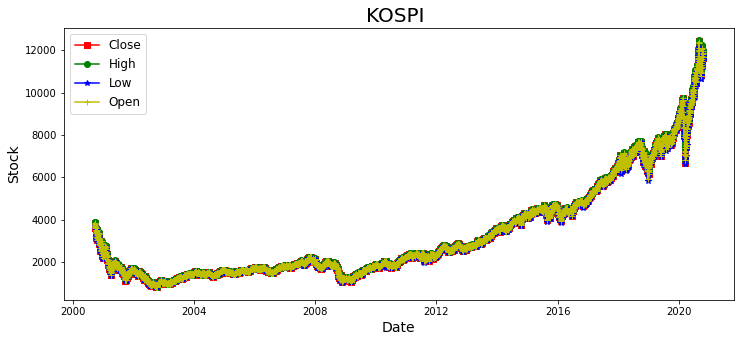

In [14]:
plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [15]:
for a in df.keys():
    print(a)

Date
Open
High
Low
Close
Adj Close
Volume


## 시계열 분해 전 각 변수의 정규분포 여부 확인(z-test)

In [16]:
for key in df.keys():
    if key != 'Date' and key != 'Adj Close' :
        _, p = ztest(df[key])
        print(f'{key} : {p}')

Open : 0.0
High : 0.0
Low : 0.0
Close : 0.0
Volume : 0.0


# 2. 시계열 분해 (Time Series Decomposition)
---
- trend, seasonal, resid로 시계열 데이터를 Decompose 한다.
- ```my_decompose``` 함수
    - 시계열 분해를 통해서 각각 컬럼의 값들을 trend, seasonal, **resid**의 3개의 데이터프레임에 각각 담아서 리턴해준다.

In [17]:
def my_decompose(df, features, freq = 50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose를 수행
    for f in features:
        result = seasonal_decompose(df[f],
                                   model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

In [18]:
tdf, sdf, rdf = my_decompose(df, features=['Open', 'High', 'Low', 'Close', 'Volume'])

## redisual의 정규분포 여부 확인 (z-test)
- title에는 칼럼별 ztest를 수행한 score로 표시하였다.
- 이 score가 0.05이하면 정규분포와 거리가 멀다는 뜻

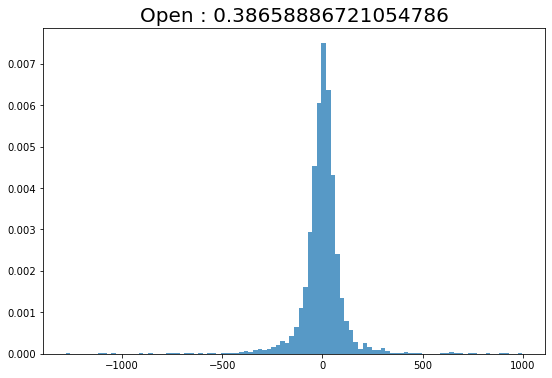

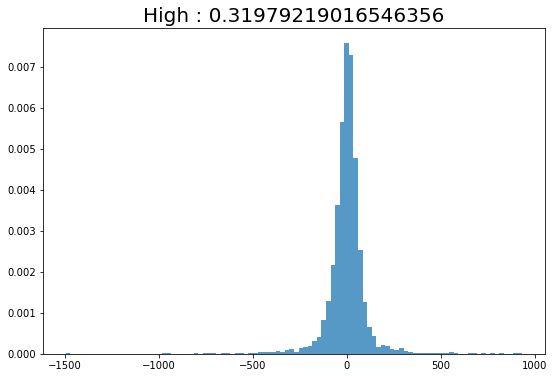

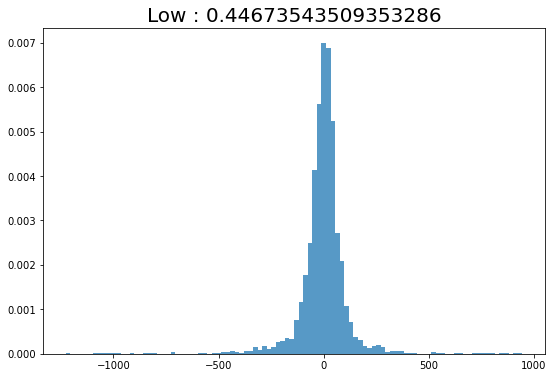

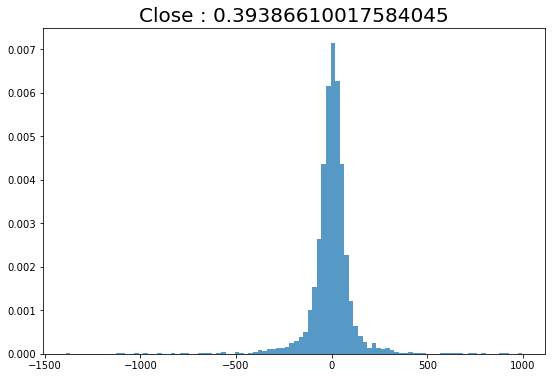

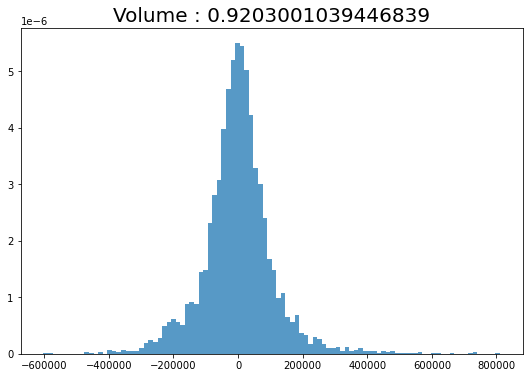

In [19]:
for key in rdf.keys():
    fig, ax = plt.subplots(figsize=(9,6))
    _, p = ztest(rdf[key])
    plt.title(f'{key} : {p}', fontsize=20)
    _ = plt.hist(rdf[key], 100, density=True, alpha=0.75)

## 4σ  기준 신뢰구간으로 이상치 찾기

각각 다음과 같은 결과를 확인할 수 있다.
1. Open
    - 89개의 이상치 데이터
2. High
    - 95개의 이상치 데이터
3. Low
    - 94개의 이상치 데이터
4. Close
    - 94개의 이상치 데이터
5. Volume
    - 85개의 이상치 데이터
---
- 하지만 각각의 이상치 데이터 후보군은 모두가 다 Outlier가 아닌 novelty(특이치)일 수도 있다.
    - 데이터 시각화를 통해서 봤을 때, 특별하게 값이 이상한 부분은 없었기 때문이다.  
    <br>  
- 그렇기 때문에 **Multi-variable Anomaly Detection**을 수행한다. 일반적으로 두가지 알고리즘을 사용한다.
    1. Clustering
        - 클러스터링을 활용하는 방법은 다음의 두 가지로 또 나뉠 수 있다.
        - K-means : 그룹 수(K)를 지정
        - DBSCAN : 그룹 수를 지정할 수 없다.
    2. Forecasting
        - Auto-Encoder로 데이터를 탐색

In [52]:
for key in rdf.keys():
    
    # 평균과 표준편차 출력
    mu, std = rdf[key].mean(), rdf[key].std()
    print(f"{key} :\n\t평균 : {mu}, 표준편차 : {std}")

    # 3-sigma(표준편차)를 기준으로 이상치 판단
    print("\t이상치 갯수:", len(rdf[key][(rdf[key]>mu+4*std)|(rdf[key]<mu-4*std)]))
    
    # 이상치 출력
    print("이상치")
    print(df.Date[rdf[key][
    (rdf[key]>mu+3*std)|(rdf[key]<mu-3*std)].index])
    print('\n' + '-'*30 +'\n')

Open :
	평균 : -1.3611681062203018, 표준편차 : 112.24940695125106
	이상치 갯수: 50
이상치
74     2001-01-03
137    2001-04-04
138    2001-04-05
3758   2015-08-25
3759   2015-08-26
          ...    
5084   2020-10-06
5085   2020-10-07
5086   2020-10-08
5096   2020-10-22
5097   2020-10-23
Name: Date, Length: 89, dtype: datetime64[ns]

------------------------------

High :
	평균 : -1.421971392506792, 표준편차 : 102.05114547399128
	이상치 갯수: 55
이상치
93     2001-01-31
137    2001-04-04
4374   2018-02-09
4394   2018-03-12
4395   2018-03-13
          ...    
5086   2020-10-08
5094   2020-10-20
5095   2020-10-21
5096   2020-10-22
5097   2020-10-23
Name: Date, Length: 95, dtype: datetime64[ns]

------------------------------

Low :
	평균 : -1.2410816082648832, 표준편차 : 116.46367200321573
	이상치 갯수: 48
이상치
88     2001-01-24
92     2001-01-30
137    2001-04-04
3757   2015-08-24
3759   2015-08-26
          ...    
5082   2020-10-02
5083   2020-10-05
5084   2020-10-06
5085   2020-10-07
5096   2020-10-22
Name: Date, Length: 94

# 3. Unsupervised Clustering으로 이상치 찾기
1. 데이터정규화
    - ```sklearn.preprocessing``` 의 ```StandartScaler```
2. K-means
3. DBSCAN

## 시계열 분해한 trend, seasonal, resid 데이터 확인

In [21]:
tdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,3330.724999,3362.220146,3298.532406,3332.609090,288057.188854
std,2400.892883,2422.863050,2379.665832,2404.825139,109834.091507
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.407500,1597.671250,1571.153750,1584.352001,220586.700000
50%,2264.797500,2292.105000,2232.207500,2265.174199,268932.110000
75%,4434.168125,4466.316875,4401.132500,4435.347500,319674.830000
max,12039.860297,12201.437499,11870.369861,12047.090432,776809.340000


In [22]:
sdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,-0.005084,-0.003891,-0.004557,-0.003745,4.370591
std,11.363539,10.507054,11.994906,11.241935,14514.475482
min,-25.238614,-25.344171,-27.703917,-24.070805,-35400.160583
25%,-5.422809,-6.246186,-8.593132,-6.193296,-11598.915336
50%,2.150852,3.141061,2.582667,2.462381,-599.165008
75%,6.705393,5.777104,7.909121,6.845566,10146.617569
max,22.388372,20.105635,20.204707,20.901232,34512.718482


In [23]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,-1.361168,-1.421971,-1.241082,-1.314223,155.136515
std,112.249407,102.051145,116.463672,110.054996,110706.241180
min,-1280.580676,-1494.706438,-1226.976539,-1390.196689,-602731.340129
25%,-38.117788,-35.393102,-38.318769,-37.788724,-53311.671523
50%,3.476876,3.331959,4.089242,2.923191,-488.997470
75%,40.164011,37.638459,41.675332,40.863314,51480.694345
max,996.954616,933.609579,944.823580,996.320780,810713.135421


### 표준 정규화
- rdf에 대해서 표본 정규화 시행

In [24]:
scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.36116811  -1.42197139  -1.24108161  -1.31422283 155.13651478]


array([[ 0.94892246,  0.84646493,  0.81728626,  0.60184276,  0.08322602],
       [ 0.49026957,  1.28420778,  1.38842808,  2.09551792,  0.10454779],
       [ 1.90750707,  2.01838985,  2.0481367 ,  2.7378712 , -0.08888583],
       ...,
       [-2.9355638 , -3.75950684, -2.18973446, -2.93558305,  0.44805172],
       [-3.02900188, -4.45234664, -3.01260131, -3.46542972,  0.39484453],
       [-3.32615554, -5.03188414, -2.82731937, -3.56760069,  0.48127544]])

### K-means활용
- Count가 20개 이하인 경우 : 3, 8, 12번 그룹
- 15개의 그룹으로 clustering

In [25]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1008',
 'group:1-count:66',
 'group:2-count:1097',
 'group:3-count:18',
 'group:4-count:296',
 'group:5-count:495',
 'group:6-count:459',
 'group:7-count:33',
 'group:8-count:19',
 'group:9-count:831',
 'group:10-count:331',
 'group:11-count:98',
 'group:12-count:11',
 'group:13-count:98',
 'group:14-count:238']

### 어떤 날들인가?
- 2018년
    - 1월 24일
    - 3월 19일
    - 10월 4일
    - 12월 4일
- 2019년
    - 5월 6, 7일
- 2020년
    - 2월~3월 + 4월 17일 : 코로나..?
    - 8월, 9월
    - 10월 13일

In [26]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[kmeans.labels_==3]

,Date,Open,High,Low,Close,Adj Close,Volume
4362,2018-01-24,6956.500000,7004.25,6888.25,6931.250000,6931.250000,526387.0
4399,2018-03-19,7043.000000,7043.00,6821.25,6914.250000,6914.250000,571979.0
4537,2018-10-04,7651.000000,7651.00,7456.50,7514.250000,7514.250000,704908.0
4578,2018-12-04,7055.250000,7055.25,6783.00,6803.250000,6803.250000,811925.0
4680,2019-05-06,7810.000000,7817.50,7667.50,7803.500000,7803.500000,630196.0
4681,2019-05-07,7744.750000,7804.00,7581.25,7674.000000,7674.000000,838952.0
4901,2020-02-24,9355.250000,9365.00,9041.25,9091.000000,9091.000000,1171879.0
4902,2020-02-25,9091.000000,9224.25,8810.00,8854.250000,8854.250000,1344897.0
4903,2020-02-26,8868.250000,9037.50,8709.50,8850.250000,8850.250000,1251412.0
4908,2020-03-03,8830.500000,9002.50,8511.00,8582.500000,8582.500000,1295648.0


In [27]:
df[kmeans.labels_==8]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


In [28]:
df[kmeans.labels_==12]

,Date,Open,High,Low,Close,Adj Close,Volume
4917,2020-03-13,7100.00,7978.000000,6942.500000,7915.750000,7915.750000,584274.0
4918,2020-03-15,7100.00,7978.000000,6942.500000,7215.250000,7215.250000,578813.0
4919,2020-03-16,7903.00,7905.250000,6927.000000,7057.500000,7057.500000,307368.0
4920,2020-03-17,7053.00,7552.250000,6948.750000,7405.250000,7405.250000,317501.0
4921,2020-03-18,7386.00,7392.250000,6830.000000,7225.250000,7225.250000,156283.0
4922,2020-03-19,7251.75,7521.500000,6894.250000,7293.500000,7293.500000,115519.0
4923,2020-03-20,7195.00,7649.000000,7153.500000,7417.979980,7417.979980,562616.0
4924,2020-03-22,6798.00,6798.000000,6628.750000,6688.750000,6688.750000,321230.0
4925,2020-03-23,6798.00,7316.250000,6628.750000,6984.500000,6984.500000,633237.0
4926,2020-03-24,7005.75,7572.250000,7005.750000,7554.750000,7554.750000,556553.0


In [29]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000,5.098000e+03
mean,3329.358747,3360.794284,3297.286767,3331.291122,3331.291122,2.882167e+05
std,2400.978546,2422.128357,2380.456260,2404.769584,2404.769584,1.595897e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1593.500000,1608.500000,1576.500000,1593.125000,1593.125000,1.907512e+05
50%,2232.000000,2259.875000,2211.750000,2232.875000,2232.875000,2.657315e+05
75%,4447.000000,4469.875000,4419.437500,4451.187500,4451.187500,3.562115e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


### 어떤 특징을 갖고 있는가?


In [30]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,0.194578,0.193084,0.252013,0.233630,-0.443905
1,-1.333821,-1.483672,-2.026410,-2.027606,3.052986
2,-0.234961,-0.237032,-0.220148,-0.218888,0.175160
3,2.867673,2.755949,2.001638,1.941786,2.835088
4,-0.019224,-0.041160,-0.306351,-0.279899,1.701011
5,0.868996,0.903342,0.935606,0.923896,-0.310361
6,-0.899405,-0.912158,-0.888788,-0.866056,0.467757
7,-4.195611,-4.554132,-4.181233,-4.167360,0.790436
8,6.092861,6.187818,6.208749,6.171515,-0.432828
9,0.316971,0.346216,0.271677,0.288842,0.449370


##### 확인 결과
- 3번 그룹 : 앞뒤 그룹에 비해서 Open, High, Low, Close가 대체로 높다.
- 8번 그룹 : 전체 값들에 비해서 Open, High, Low, Close가 높다.
- 12번 그룹 : 전체 값들에 비해서 OPen, High, Low, Close가 매우 낮다.

### 왜 이상치로 분류된건가?
- 그래프를 시각화해본다.
- 12번 그룹의 경우 폭락장이 있었던 것을 확인할 수 있었다.

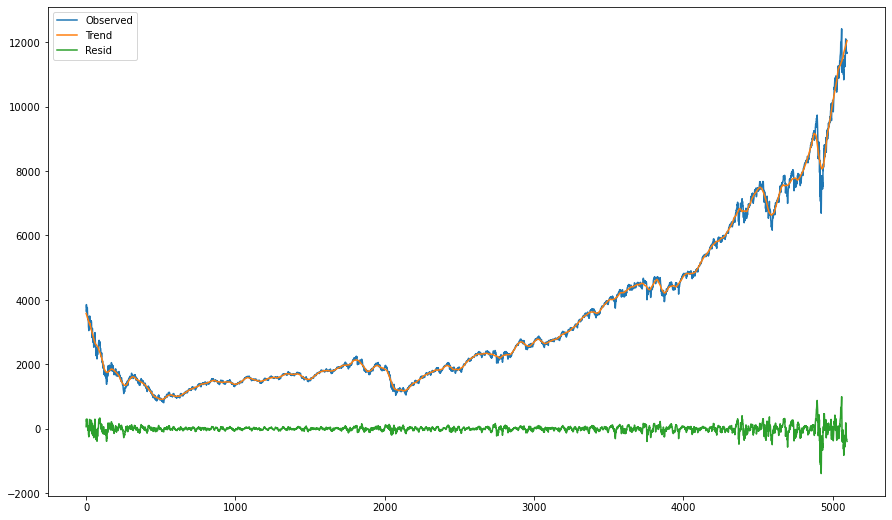

In [33]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

## DBSCAN으로 이상치 찾기 
- ```eps = 0.7```
- ```min_samples = 3```
- 12개, 3개, 3개의 소수그룹을 분리해냈다.

In [35]:
clustering = DBSCAN(eps=0.7, min_samples=3).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=3)

In [36]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  0 ... -1 -1 -1]


In [37]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:241',
 'group:0-count:4839',
 'group:1-count:12',
 'group:2-count:3',
 'group:3-count:3']

# 4. Auto-Encoder를 이용한 이상치 탐색

## 라이브러리 import 

In [38]:
# 필요한 라이브러리를 불러옵니다
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [39]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [40]:
# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

### ```keras```의 ```TimeseriresGenerator```를 활용, 데이터셋 만들기

In [41]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


## 모델 생성

In [42]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [43]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [44]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
155/159 [============================>.] - ETA: 0s - loss: 1.5285 - mae: 1.5285
Epoch 00001: val_loss improved from inf to 1.65466, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 2s 15ms/step - loss: 1.5166 - mae: 1.5166 - val_loss: 1.6547 - val_mae: 1.6547
Epoch 2/50
158/159 [============================>.] - ETA: 0s - loss: 0.5434 - mae: 0.5434
Epoch 00002: val_loss improved from 1.65466 to 0.82181, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 1s 9ms/step - loss: 0.5414 - mae: 0.5414 - val_loss: 0.8218 - val_mae: 0.8218
Epoch 3/50
154/159 [============================>.] - ETA: 0s - loss: 0.4984 - mae: 0.4984
Epoch 00003: val_loss improved from 0.82181 to 0.62576, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 2s 10ms/step - loss: 0.4951 - mae: 0.4951 - va

In [45]:
model.load_weights(checkpoint_path)

## 오토인코더 그래프 시각화

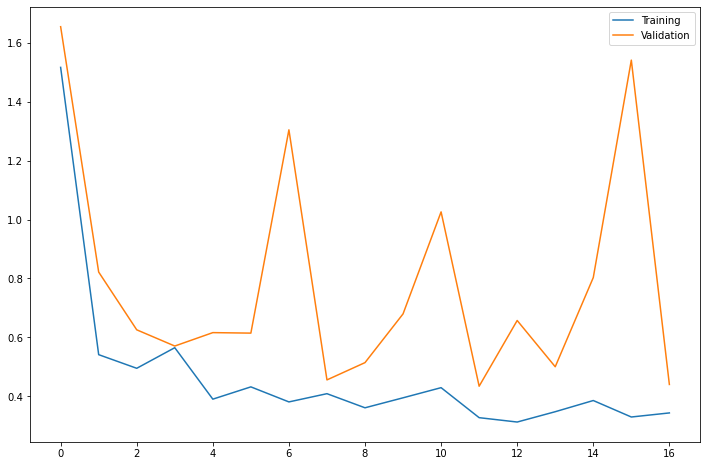

In [46]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

### 주의!
시계열 데이터를 window_size만큼 밀어가면서 예측하는 모델을 만들었다.  
그래서 train_gen의 길이는 원본 df의 길이보다 window_size 만큼 짧다.  
예측결과와 비교할때는 scaled의 앞에서 window_size만큼을 건너 뛰어야한다.

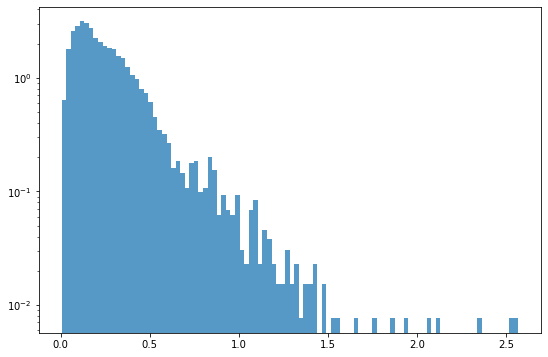

In [47]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]  # window_size만큼 건너 뛰어야한다

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

## mae_loss가 2 이상인 샘플을 확인해본다.
- 실제 앞에서 확인했던 이상치인 2020년 초, 코로나가 퍼지기 시작한 시기와 비슷하다.

In [48]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 2
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4894,2020-02-27,8811.50,8878.50,8334.25,8382.75,8382.75,1580041.0,2.117563
4895,2020-02-28,8347.00,8574.75,8126.25,8454.00,8454.00,1527204.0,2.079259
4896,2020-03-01,8347.00,8574.75,8126.25,8382.75,8382.75,1513887.0,2.359392
4897,2020-03-02,8349.25,8883.25,8224.25,8791.25,8791.25,1373357.0,2.525272
4898,2020-03-03,8830.50,9002.50,8511.00,8582.50,8582.50,1295648.0,2.567134


- mae_loss가 1.5 이상인 샘플도 확인해본다.
    - 앞에서 확인했던 2018년 10월의 데이터도 포함이 되어 있다.
    - 거기에 더해서 코로나 시기의 데이터 또한 포함되어 있다.

In [50]:
threshold = 1.5
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4543,2018-10-26,6882.00,6986.50,6734.25,6893.25,6893.25,1069548.0,1.528084
4892,2020-02-25,9091.00,9224.25,8810.00,8854.25,8854.25,1344897.0,1.667264
4894,2020-02-27,8811.50,8878.50,8334.25,8382.75,8382.75,1580041.0,2.117563
4895,2020-02-28,8347.00,8574.75,8126.25,8454.00,8454.00,1527204.0,2.079259
4896,2020-03-01,8347.00,8574.75,8126.25,8382.75,8382.75,1513887.0,2.359392
4897,2020-03-02,8349.25,8883.25,8224.25,8791.25,8791.25,1373357.0,2.525272
4898,2020-03-03,8830.50,9002.50,8511.00,8582.50,8582.50,1295648.0,2.567134
4899,2020-03-04,8557.50,8950.00,8508.25,8896.50,8896.50,939032.0,1.750712
4900,2020-03-05,8889.00,8899.75,8610.75,8648.75,8648.75,954104.0,1.546771
4920,2020-03-29,7395.75,7507.25,7367.25,7489.25,7489.25,1256384.0,1.940968


## 그래프로 이상치를 확인해본다.

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


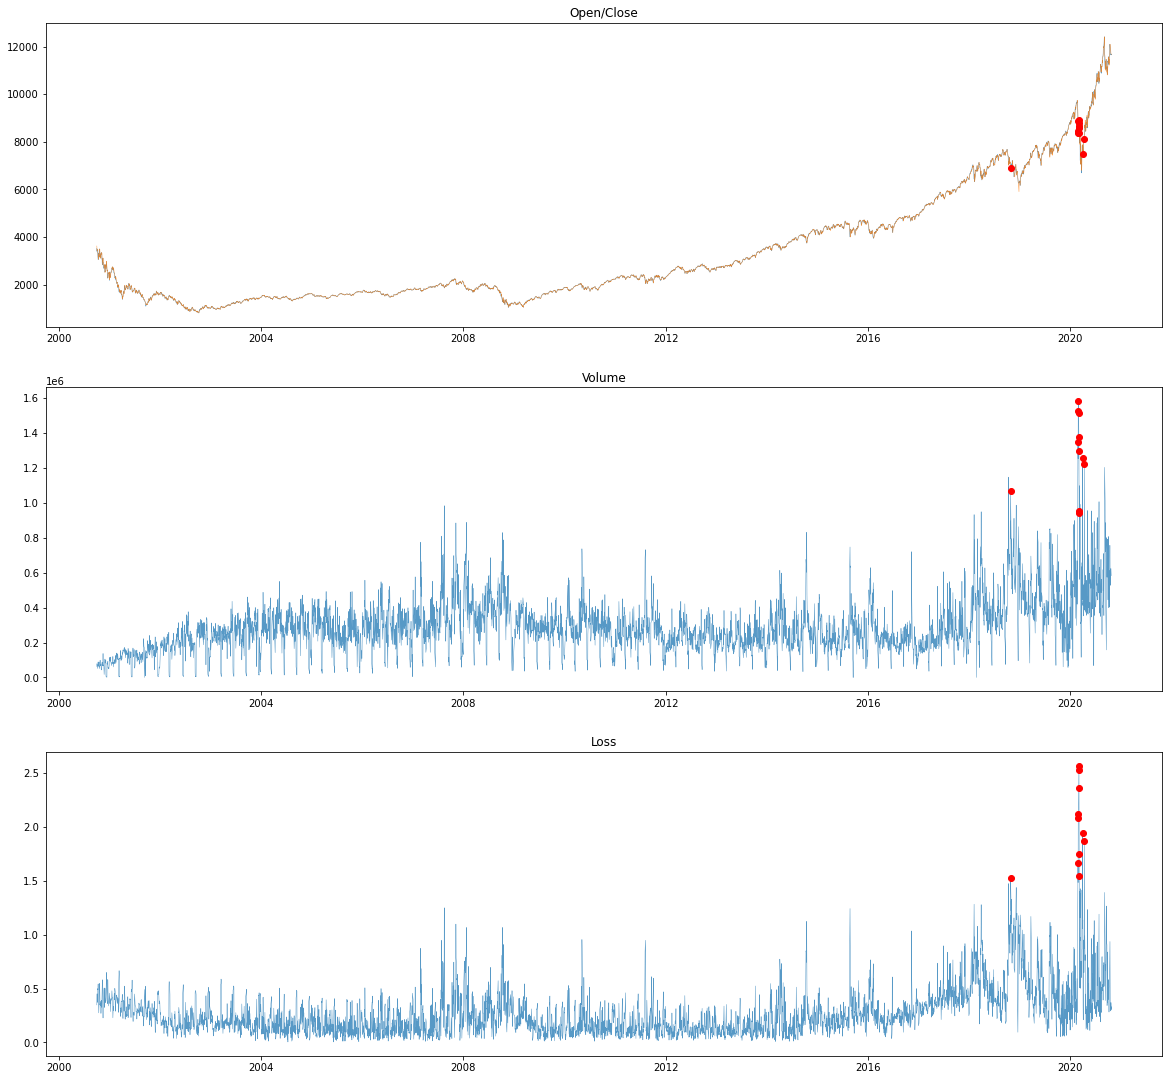

In [51]:
fig = plt.figure(figsize=(20,19))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

# 정리
---
1. 시계열의 Residual에 대한 분석을 통해 신뢰구간 4σ밖의 데이터를 확인
    - 2001년 초의 데이터와 2020년 데이터가 제일 먼저 보인다.
    - 이는 2001년 미국에서 금리인하를 하게 되면서 나스닥이 많이 떨어졌었다.
    - 그와 동시에 2020년 코로나시기가 잘 포함되어 있다.  
    
> 이러한 데이터는 수치상의 에러인 이상치로는 생각하기 힘들고, 어떠한 상황에 있는 특이치로 생각을 할 수 있다.
   
2. k-mean, DBSCAN을 통해서 이상치를 찾아본다.
    - 2018년 10월은 미국 증시가 하락한 '검은 수요일'이다.
    - 2019년 5월에는 트럼프가 중국의 아이티 회사인 화웨이에 대한 제재방침을 발표하면서 나스닥이 하락한 시기이다.
    - 2020년 초반부에는 코로나가 퍼지면서 나스닥에 전반적인 영향을 끼쳤을 것이다.

> 이것 또한 어떠한 수치의 이상이 아닌 그 시기의 어떠한 특정 일때문에 자연스로운 나스닥의 등락이 보여지는 것이기에 이상치라고 보기엔 힘들것 같다. 특이치로 생각을 했다.

3. LSTM 오토인코더의 학습은 Validation의 곡선은 가끔 튀는 것을 볼수 있지만 우하향하는 그래프를 확인 할 수 있었다. Training의 경우는 안정적으로 우하향되는 그래프가 보여졌고 학습을 제대로 진행한 것으로 확인하였다.
    - 실제로 mae_loss를 2로 기준을 두었을 경우 2020년 초반의 코로나에 대한 날짜를 확인 할 수 있었다.
    - mae_loss가 1.5로 설정했을 때는 미국 증시의 '검은 수요일'을 확인할 수 있었다.
    - 앞에서 확인했던 날짜들과 대체로 비슷한 결과를 확인할 수 있었다.